In [1]:
# Tip: set environment variable WRDS_USERNAME to skip the username prompt
import os
import wrds
import pandas as pd
from dotenv import load_dotenv
import matplotlib.pyplot as plt

load_dotenv()

# Optional: read WRDS username from environment (WRDS_USER)
wrds_user = os.getenv("WRDS_USER")

# Connect to WRDS (prompts for credentials if not cached)
conn = wrds.Connection(wrds_username=wrds_user)

WRDS recommends setting up a .pgpass file.
pgpass file created at C:\Users\Dell\AppData\Roaming\postgresql\pgpass.conf
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


        date  permno        prc       ret      retx     shrout  cfacpr  \
0 2020-01-02   14593  300.35001  0.022816  0.022816  4384027.0     4.0   
1 2020-01-03   14593  297.42999 -0.009722 -0.009722  4384027.0     4.0   
2 2020-01-06   14593  299.79999  0.007968  0.007968  4384027.0     4.0   
3 2020-01-07   14593  298.39001 -0.004703 -0.004703  4384027.0     4.0   
4 2020-01-08   14593     303.19  0.016086  0.016086  4384027.0     4.0   

     adj_prc  
0  75.087502  
1  74.357497  
2  74.949997  
3  74.597503  
4    75.7975  


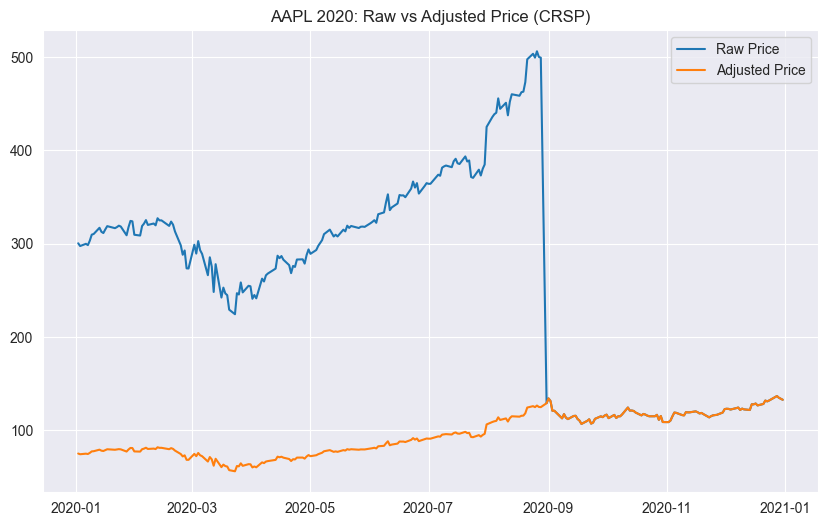

In [4]:
# Download daily Apple (AAPL) data for 2020 from CRSP

# AAPL PERMNO is 14593
aapl_data = conn.raw_sql("""
    SELECT date, permno, prc, ret, retx, shrout, cfacpr
    FROM crsp.dsf
    WHERE permno = 14593
      AND date BETWEEN '2020-01-01' AND '2020-12-31'
    ORDER BY date
""", date_cols=['date'])

# CRSP stores price as negative for bid/ask average -> take absolute value
aapl_data['prc'] = aapl_data['prc'].abs()

# Adjusted price using CRSP adjustment factor
aapl_data['adj_prc'] = aapl_data['prc'] / aapl_data['cfacpr']

print(aapl_data.head())

# Quick plot: raw vs adjusted price
plt.figure(figsize=(10,6))
plt.plot(aapl_data['date'], aapl_data['prc'], label='Raw Price')
plt.plot(aapl_data['date'], aapl_data['adj_prc'], label='Adjusted Price')
plt.legend()
plt.title("AAPL 2020: Raw vs Adjusted Price (CRSP)")
plt.show()


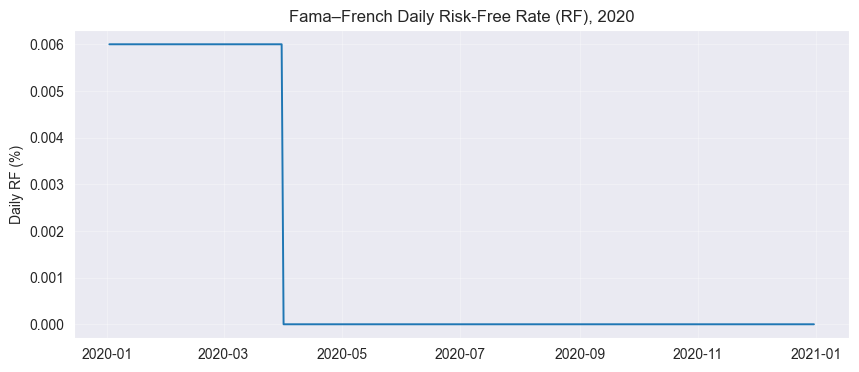

In [5]:
# --- Fetch Fama–French daily risk-free rate (RF) for 2020 and plot
# 1) Download RF from WRDS Fama–French library (daily factors)
ff_rf = conn.raw_sql("""
    SELECT date, rf
    FROM ff.factors_daily
    WHERE date BETWEEN '2020-01-01' AND '2020-12-31'
    ORDER BY date
""", date_cols=['date'])


# 2) Plot daily RF over 2020
plt.figure(figsize=(10,4))
plt.plot(ff_rf['date'], ff_rf['rf']*100.0, lw=1.4)
plt.title("Fama–French Daily Risk-Free Rate (RF), 2020")
plt.ylabel("Daily RF (%)")
plt.xlabel("")
plt.grid(True, alpha=0.3)
plt.show()

# 3) (Optional) Merge RF into your AAPL dataframe for later excess-return calc
aapl_2020 = aapl_data.merge(ff_rf, on='date', how='left', validate='one_to_one')

# Example columns now available:
# aapl_2020[['date','prc','adj_prc','ret','retx','rf']].head()


Text(0.5, 1.0, 'AAPL 2020: Return Comparison Around Stock Split')

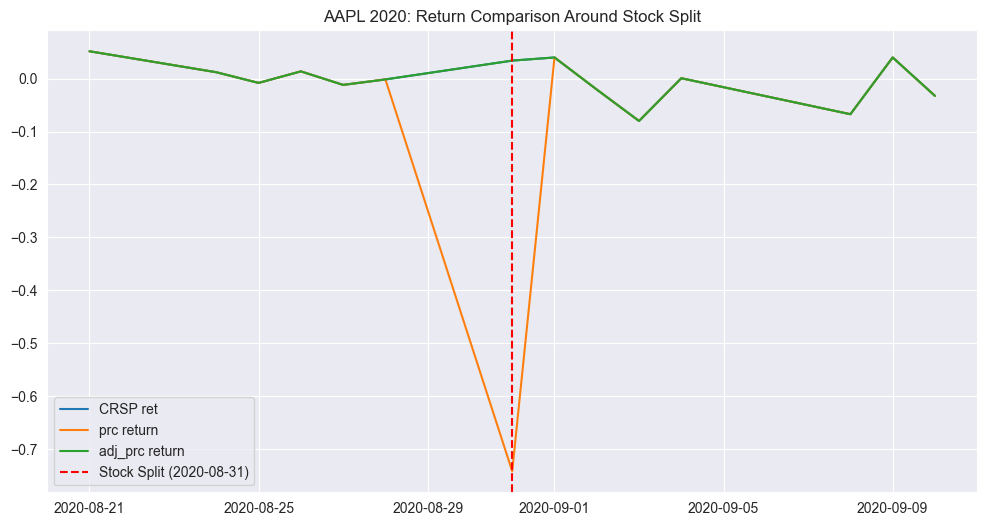

In [9]:
# 1. Calculate simple return using prc
aapl_2020['prc_return'] = aapl_2020['prc'].pct_change()

# 2. Calculate simple return using adj_prc
aapl_2020['adj_prc_return'] = aapl_2020['adj_prc'].pct_change()

split_date = pd.to_datetime('2020-08-31')
mask = (aapl_2020['date'] >= split_date - pd.Timedelta(days=10)) & (aapl_2020['date'] <= split_date + pd.Timedelta(days=10))
split_window = aapl_2020.loc[mask]

# 3. Compare ret, retx, prc_return, adj_prc_return
plt.figure(figsize=(12,6))
plt.plot(split_window['date'], split_window['ret'], label='CRSP ret')
plt.plot(split_window['date'], split_window['prc_return'], label='prc return')
plt.plot(split_window['date'], split_window['adj_prc_return'], label='adj_prc return')
plt.axvline(split_date, color='red', linestyle='--', label='Stock Split (2020-08-31)')
plt.legend()
plt.title('AAPL 2020: Return Comparison Around Stock Split')

    permno       date      paydt  distcd  divamt
2    14593 2020-02-07 2020-02-13    1232    0.77
10   14593 2020-05-08 2020-05-14    1232    0.82
15   14593 2020-08-07 2020-08-13    1232    0.82
16   14593 2020-08-31 2020-08-28    5523     0.0
37   14593 2020-11-06 2020-11-12    1232   0.205


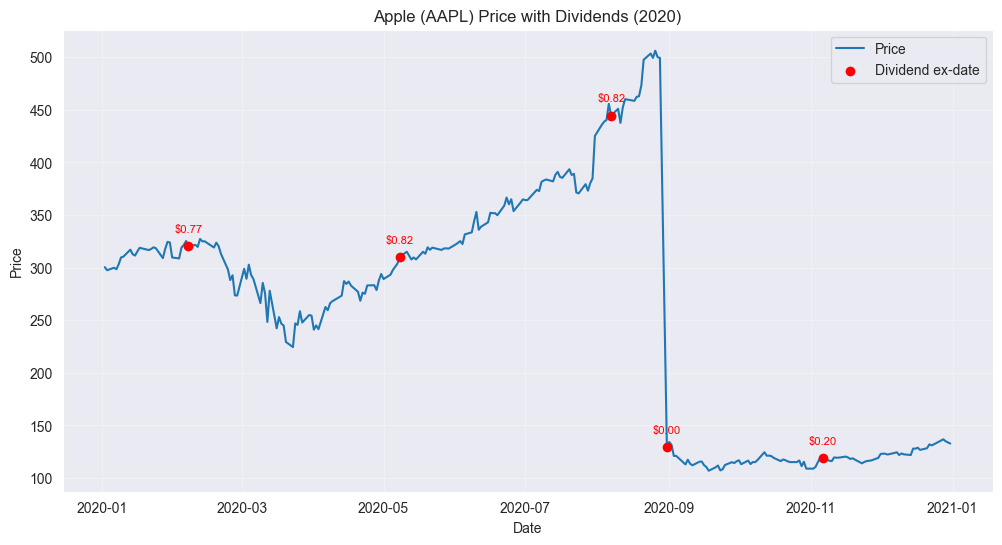

In [18]:
# --- 1. Download Apple dividends from CRSP dividend events (dse)
aapl_div = conn.raw_sql("""
    SELECT permno, date, paydt, distcd, divamt
    FROM crsp.dse
    WHERE permno = 14593
      AND date BETWEEN '2020-01-01' AND '2020-12-31'
    ORDER BY date
""", date_cols=['date','paydt'])

print(aapl_div.dropna(how='any'))

# --- 2. Merge dividends with your AAPL daily data
# aapl_data already contains your 2020 daily price series
aapl_with_div = aapl_2020.merge(aapl_div[['date','divamt']], on='date', how='left')

# --- 3. Plot stock price with dividend markers
plt.figure(figsize=(12,6))
plt.plot(aapl_with_div['date'], aapl_with_div['prc'], label="Price")

# Mark dividend ex-dates
div_days = aapl_with_div.dropna(subset=['divamt'])
plt.scatter(div_days['date'], div_days['prc'], color='red', zorder=5, label='Dividend ex-date')

# Annotate dividend amounts
for _, row in div_days.iterrows():
    plt.annotate(f"${row['divamt']:.2f}",
                 (row['date'], row['prc']),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')

plt.title("Apple (AAPL) Price with Dividends (2020)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

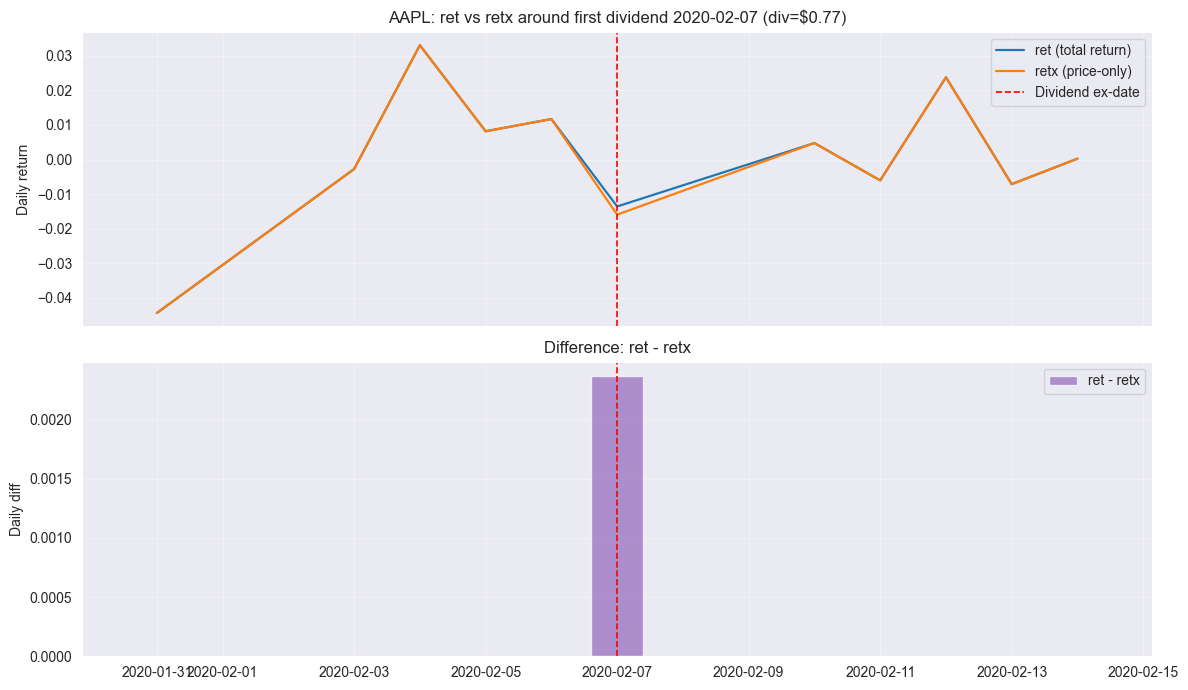

In [21]:
# Ensure sorted by date and continuous index
w = aapl_with_div.sort_values('date').reset_index(drop=True)

# Find the first cash dividend date
div_mask = w['divamt'].fillna(0) > 0
if not div_mask.any():
    print("No dividend found in the dataset.")
else:
    first_div_date = w.loc[div_mask, 'date'].iloc[0]
    first_div_amt = w.loc[div_mask, 'divamt'].iloc[0]

    # Build a +/- N trading-day window
    half_window = 5
    idx = w.index[w['date'] == first_div_date][0]
    lo = max(0, idx - half_window)
    hi = min(len(w) - 1, idx + half_window)
    win = w.loc[lo:hi].copy()

    # Difference between total and ex-dividend returns
    win['ret_diff'] = win['ret'] - win['retx']

    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True)

    # Top: ret vs retx
    axes[0].plot(win['date'], win['ret'],  label='ret (total return)', lw=1.6)
    axes[0].plot(win['date'], win['retx'], label='retx (price-only)', lw=1.6)
    axes[0].axvline(first_div_date, color='red', ls='--', lw=1.2, label='Dividend ex-date')
    axes[0].set_title(f"AAPL: ret vs retx around first dividend {first_div_date.date()} (div=${first_div_amt:.2f})")
    axes[0].set_ylabel("Daily return")
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Bottom: difference (ret - retx)
    axes[1].bar(win['date'], win['ret_diff'], color='tab:purple', alpha=0.7, label='ret - retx')
    axes[1].axvline(first_div_date, color='red', ls='--', lw=1.2)
    axes[1].set_title("Difference: ret - retx")
    axes[1].set_ylabel("Daily diff")
    axes[1].grid(alpha=0.3)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

<Axes: >

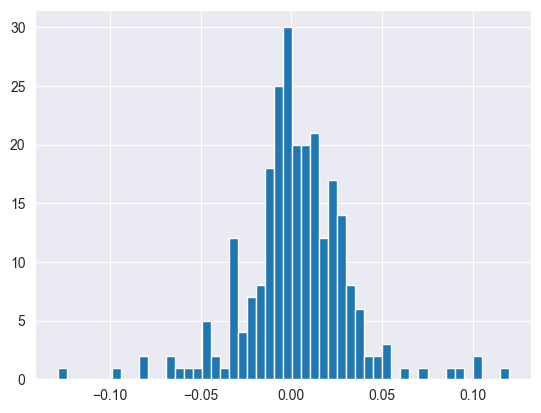

In [24]:
aapl_2020['ret'].hist(bins=50)

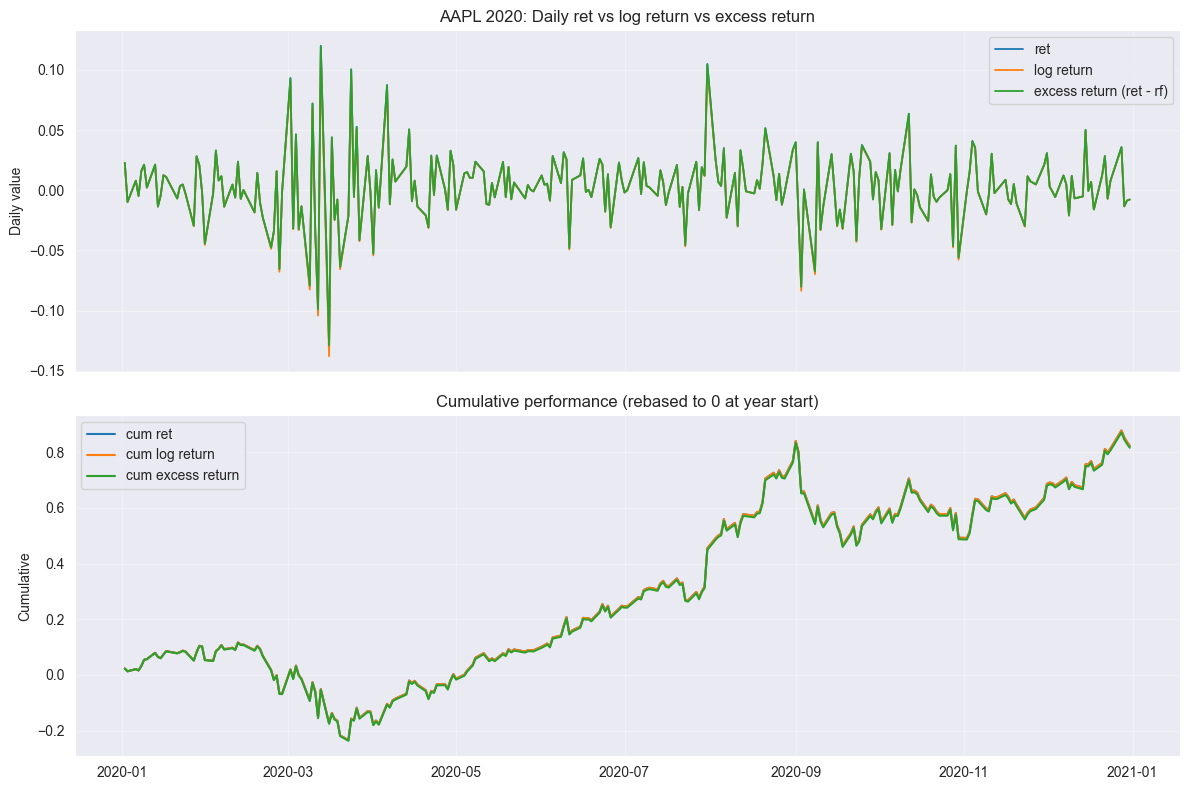

In [25]:
import numpy as np

# Ensure sorted by date
df = aapl_2020.sort_values('date').copy()

# 1) Compute metrics
# Daily log return
df['log_ret'] = np.log1p(df['ret'])
# Daily excess return (total return minus risk-free)
df['excess_ret'] = df['ret'] - df['rf']

# 2) Build cumulative performance rebased to year start
gross_ret = (1.0 + df['ret'].fillna(0.0)).cumprod()
gross_log = np.exp(df['log_ret'].fillna(0.0).cumsum())
gross_excess = (1.0 + df['excess_ret'].fillna(0.0)).cumprod()

df['cum_ret'] = gross_ret - 1.0
df['cum_log_ret'] = gross_log - 1.0
df['cum_excess_ret'] = gross_excess - 1.0

# 3) Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Top: daily series
axes[0].plot(df['date'], df['ret'],         label='ret', lw=1.3)
axes[0].plot(df['date'], df['log_ret'],     label='log return', lw=1.3)
axes[0].plot(df['date'], df['excess_ret'],  label='excess return (ret - rf)', lw=1.3)
axes[0].set_title('AAPL 2020: Daily ret vs log return vs excess return')
axes[0].set_ylabel('Daily value')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Bottom: cumulative performance
axes[1].plot(df['date'], df['cum_ret'],        label='cum ret', lw=1.5)
axes[1].plot(df['date'], df['cum_log_ret'],    label='cum log return', lw=1.5)
axes[1].plot(df['date'], df['cum_excess_ret'], label='cum excess return', lw=1.5)
axes[1].set_title('Cumulative performance (rebased to 0 at year start)')
axes[1].set_ylabel('Cumulative')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()